<font size=20>**Using SHAP Values for Model Interpretability**<font>

In [1]:
#!pip install shap
#!pip install shap
#! pip install dice-ml


# Imports

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import dice_ml

import pickle
import shap
shap.initjs()


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Loading Data

In [3]:
df = pd.read_csv('../processed_data/cleaned_data_final.csv')
df.head(5)


,name,male,origin,isMarried,isNoble,popularity,isAlive,season,episode,deaths,episode_num
0,Viserys II Targaryen,1,House Targaryen,0,0,0.605351,0,8,The Bells,Lord Varys - Burned alive by Drogon with his f...,71
1,Walder Frey,1,House Frey,1,1,0.896321,0,6,The Winds of Winter,Lord Walder Frey - Throat slit by Arya Stark w...,60
2,Addison Hill,1,House Lannister,0,1,0.267559,1,0,NaN,NaN,0
3,Aemma Arryn,0,House Arryn,1,1,0.183946,0,5,The Gift,Maester Aemon Targaryen - Died of natural causes.,47
4,Sylva Santagar,0,House Martell,1,1,0.043478,1,0,NaN,NaN,0


## Setting X and y

In [4]:
X = df
X = X.drop(columns = ["name",'isAlive','episode','deaths','season',
       'episode_num'], axis=1)


y = df[["isAlive"]]

print(f'Features: {X.columns},\n \ny.head(5):\n{y.head()}')


Features: Index(['male', 'origin', 'isMarried', 'isNoble', 'popularity'], dtype='object'),
 
y.head(5):
   isAlive
0        0
1        0
2        1
3        0
4        1


In [5]:
model_xgb = pickle.load(open( "../got_survival/models_pickle/death_model.pkl", "rb"))


In [6]:
model_xgb


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('standar_scaler',
                                                                   StandardScaler())]),
                                                  ['popularity']),
                                                 ('cat_transformer',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['origin']),
                                                 ('passthrough', 'passthrough',
                                                  ['isMarried', 'isNoble',
                                                   'male'])])),
                ('xgbclassifier',
                 XGBClassifier(base_sc...
                               feature_types=None, gamma=0.558,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.024, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=4,
                               max_leaves=None, min_child_weight=6, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [7]:
model_xgb.__dict__


{'steps': [('columntransformer',
   ColumnTransformer(transformers=[('num_transformer',
                                    Pipeline(steps=[('standar_scaler',
                                                     StandardScaler())]),
                                    ['popularity']),
                                   ('cat_transformer',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    ['origin']),
                                   ('passthrough', 'passthrough',
                                    ['isMarried', 'isNoble', 'male'])])),
  ('xgbclassifier',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, device=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric='logloss',
                 feature_typ

In [8]:
X_processed = model_xgb["columntransformer"].transform(X)


In [9]:
model_xgb["xgbclassifier"].predict(X_processed)


array([0, 0, 0, ..., 1, 1, 0])

In [10]:
X_processed.shape


(1949, 24)

In [11]:
shap.initjs()

# Calculate SHAP values
X100 = shap.utils.sample(X_processed, 1949) #Before 200
explainer = shap.TreeExplainer(model_xgb["xgbclassifier"],X100)
shap_values = explainer(X_processed)


[20:26:15] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


 93%|=================== | 1822/1949 [00:15<00:01]       

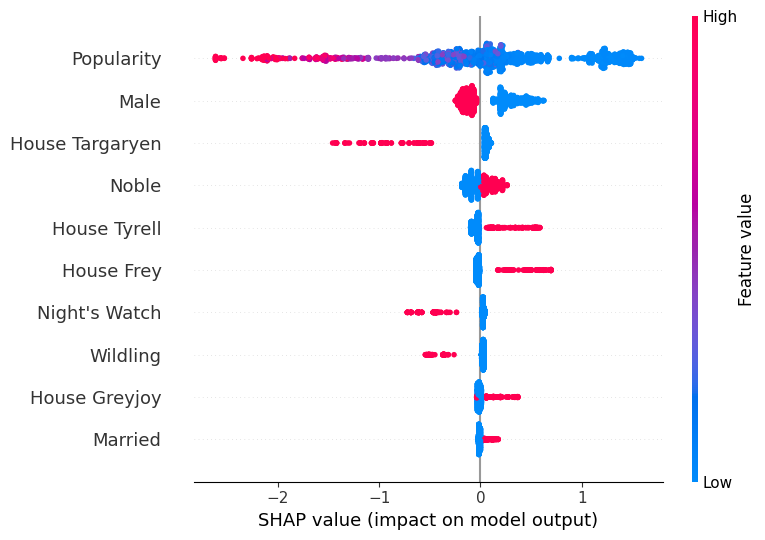

In [12]:
test = pd.DataFrame(X_processed)
#test.columns = [x.split("__")[1] for x in model_xgb["columntransformer"].get_feature_names_out()]
test.columns = ['Popularity', 'Dothraki', 'Foreign Noble',
       'Foreign Peasant', 'House Arryn',
       'House Baratheon', 'House Bolton', 'House Frey',
       'House Greyjoy', 'House Lannister', 'House Martell',
       'House Stark', 'House Targaryen',
       'House Tully', 'House Tyrell', "Night's Watch",
       'Noble', 'Outlaw', 'Peasant', 'Soldier',
       'Wildling', 'Married', 'Noble', 'Male']
shap.summary_plot(shap_values, test, max_display=10)


In [13]:
shap_values_array = np.array([ex.values for ex in shap_values])


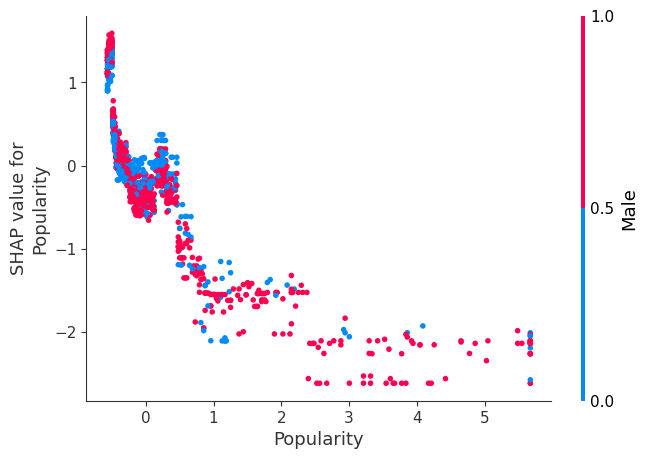

In [14]:
shap.dependence_plot("Popularity", shap_values_array, test,interaction_index="Male")


In [15]:
explainer.expected_value


0.9708860404302223

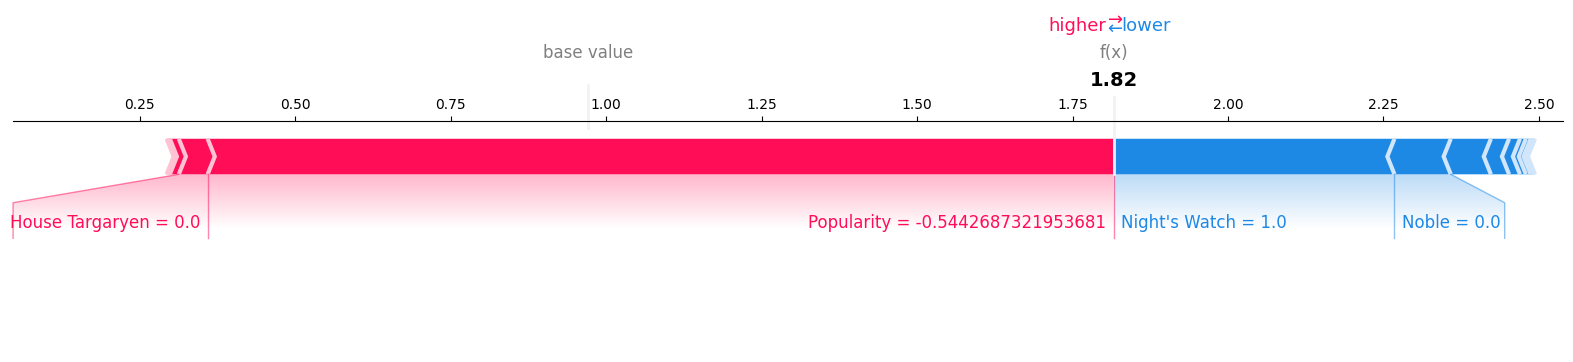

In [16]:
shap.plots.force(explainer.expected_value, shap_values_array[12,:], test.iloc[12, :], matplotlib = True)


In [17]:
y.iloc[25, :]


isAlive    0
Name: 25, dtype: int64

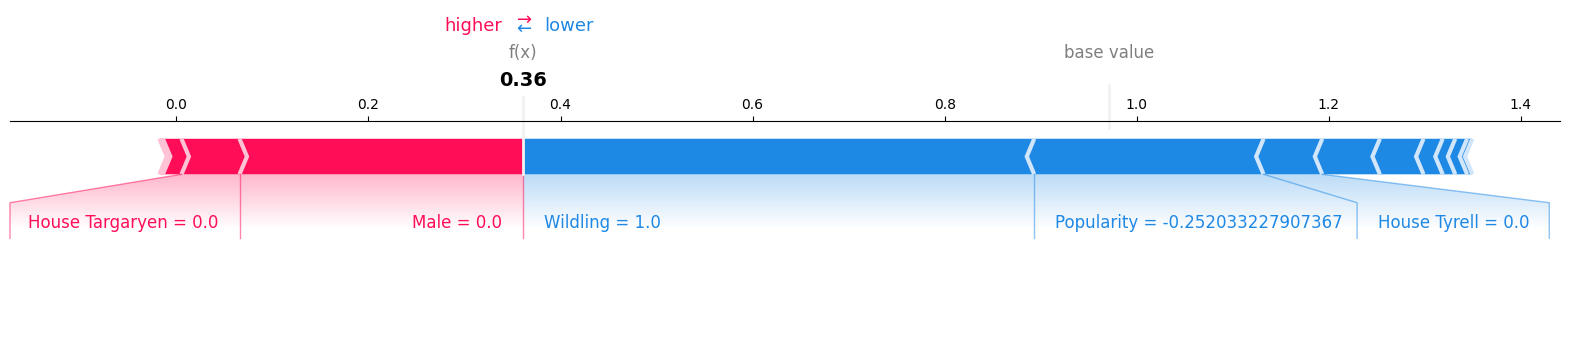

In [18]:
shap.plots.force(explainer.expected_value, shap_values_array[25,:], test.iloc[25, :], matplotlib = True)


isAlive    1
Name: 13, dtype: int64


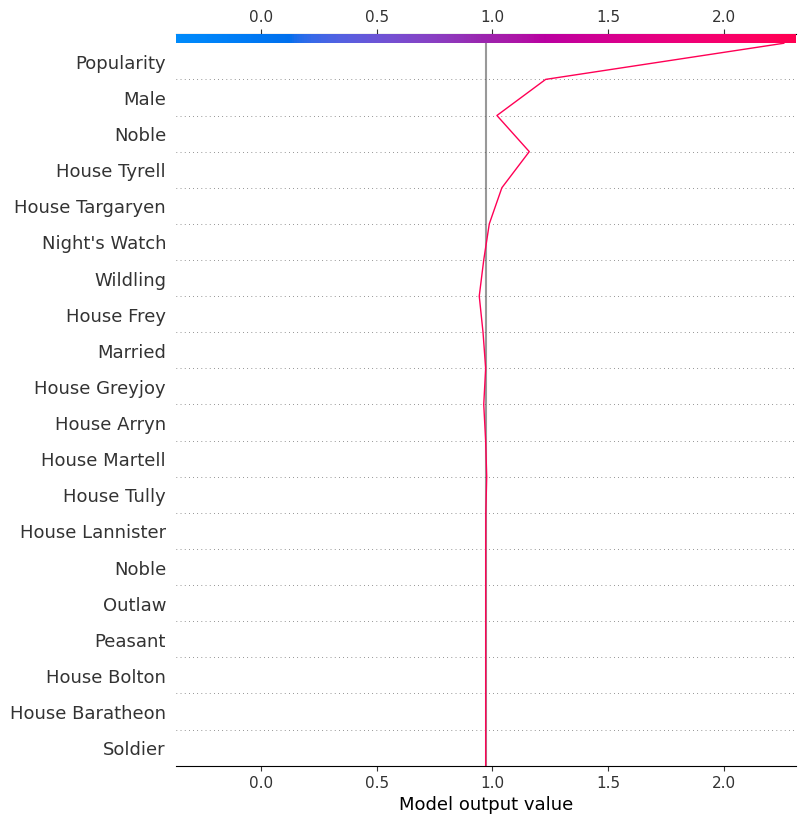

In [19]:
print(y.iloc[13, :])
shap.decision_plot(explainer.expected_value, shap_values_array[13,:], test.columns)


isAlive    0
Name: 3, dtype: int64


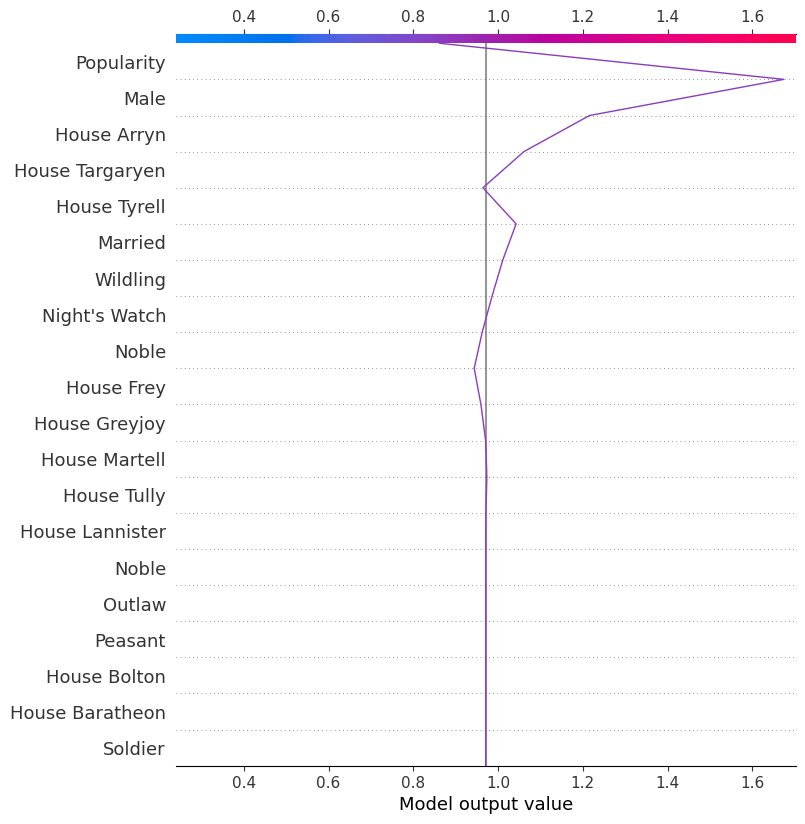

In [20]:
print(y.iloc[3, :])
shap.decision_plot(explainer.expected_value, shap_values_array[3,:], test.columns)


# Joao's code

In [ ]:
#[x.split("__")[1] for x in model_xgb["columntransformer"].get_feature_names_out()]


In [ ]:
#test = pd.DataFrame(X_processed)
#test.columns = [x.split("__")[1] for x in model_xgb["columntransformer"].get_feature_names_out()]
#shap.summary_plot(shap_values, test)


In [ ]:
#i = 3 #Unpopular Targaryen -> 38
#sample = test.iloc[i:i+1]
#shap_values = explainer(sample)
#print(model_xgb["xgbclassifier"].predict(sample))
#print(sample.loc[i])
#shap.summary_plot(shap_values, sample)


In [21]:
type(test)
test.shape, y.shape


((1949, 24), (1949, 1))

In [22]:
test2 = pd.concat([test, y], axis=1)


In [25]:
print(test2.columns)


Index(['Popularity', 'Dothraki', 'Foreign Noble', 'Foreign Peasant',
       'House Arryn', 'House Baratheon', 'House Bolton', 'House Frey',
       'House Greyjoy', 'House Lannister', 'House Martell', 'House Stark',
       'House Targaryen', 'House Tully', 'House Tyrell', 'Night's Watch',
       'Noble', 'Outlaw', 'Peasant', 'Soldier', 'Wildling', 'Married', 'Noble',
       'Male', 'isAlive'],
      dtype='object')


In [ ]:
str()


In [30]:
test2_cols = test2.columns.tolist()
type(test2_cols), test2_cols[:-1]


(list,
 ['Popularity',
  'Dothraki',
  'Foreign Noble',
  'Foreign Peasant',
  'House Arryn',
  'House Baratheon',
  'House Bolton',
  'House Frey',
  'House Greyjoy',
  'House Lannister',
  'House Martell',
  'House Stark',
  'House Targaryen',
  'House Tully',
  'House Tyrell',
  "Night's Watch",
  'Noble',
  'Outlaw',
  'Peasant',
  'Soldier',
  'Wildling',
  'Married',
  'Noble',
  'Male'])

In [32]:

# Dataset for training an ML model
d = dice_ml.Data(dataframe=test2,
                 continuous_features=test2_cols[:-1],
                 outcome_name='isAlive')

# Pre-trained ML model
m = dice_ml.Model(model_xgb["xgbclassifier"], backend='sklearn')
# DiCE explanation instance
exp = dice_ml.Dice(d,m)


AttributeError: 'DataFrame' object has no attribute 'dtype'

In [ ]:
e1 = exp.generate_counterfactuals(test[i:i+1], total_CFs=2, desired_class="opposite")
e1.visualize_as_dataframe(show_only_changes=True)


NameError: name 'exp' is not defined

In [ ]:
e1 = exp.generate_counterfactuals(test[i:i+1], total_CFs=2, desired_class="opposite")
e1.visualize_as_dataframe(show_only_changes=True)
